# **Algorithmic trading strategies with machine learning**

**Important Glossary**
- **The forecast horizon** is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).
- **Stationary and non-stationary**
- **noise** 

Problem statements:
- Inability to stay up to 24/7 to monitor trading opportunity
- interference of emotion and any point of time, led to possiblility of mistrade
- as ROI and max drawdown can be roughly estimated, risk of portfolio allocation 
- 
<!-- - hard to assess risk max drawdown and  -->

Goal:
- educate on type of trading strategies
- learn how to apply and improve algorithmic trading strategies with machine learning 
- Gain more 100% annualized gain on backtesting 
- win rate more than 40%
- max drawdown less than -50%
- obtains better returns than buy-and-hold over the sampled time

Business Objective:  
- improved trading accuracy as the algo can execute order at the best price as possible
- retain same or more profit as human but instead using our strategies
- increase in speed of order excution such as sudden crash of market
- reduct cost of transaction as trader don't have to monitor all the time

Scope:
- Study of Bitcoin market behavior and price movements
- Build trading strategies with machine learning mainly on BTC 1D time-series data  
- as different strategies suit different market condition and timeframe
- possible strategie with 1D timeframe:
    - trend following
- possible strategie on 1h timeframe:
    - High Frequency Trading

Performance Criteria:  
- Accuracy
- Precision, Recall, F1-Score
- Cumulative gain
- Annualized return
- Accumulative portfolio value


In [1]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

import talib
import ta
import pandas_ta as pta
from finta import TA

Starting new HTTPS connection (1): api.segment.io


# **Data Acquisition**

load data into the workspace with extracted data from tradingview

## **Daily Timeframe**

In [2]:
btc_df = pd.read_csv("mini_data/BTCUSD.csv")
btc_df = btc_df[["time", "open", "high", "low", "close", "Volume"]].rename(columns = {"open": "Open", "high": "High", "low": "Low", "close": "Close"})
# btc_df.set_index("time", inplace=True)
btc_df.head()

time   Open   High    Low  Close    Volume
0  1313625600  10.90  10.90  10.90  10.90  0.489908
1  1313712000  11.85  11.85  11.15  11.69  1.926578
2  1313798400  11.70  11.70  11.70  11.70  0.085470
3  1313884800  11.70  11.70  11.70  11.70  0.085470
4  1313971200  11.70  11.70  11.70  11.70  0.028632

In [3]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3830 entries, 0 to 3829
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    3830 non-null   int64  
 1   Open    3830 non-null   float64
 2   High    3830 non-null   float64
 3   Low     3830 non-null   float64
 4   Close   3830 non-null   float64
 5   Volume  3830 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 179.7 KB


## **Daily from Binance data**

https://medium.com/swlh/retrieving-full-historical-data-for-every-cryptocurrency-on-binance-bitmex-using-the-python-apis-27b47fd8137f

In [46]:
btc_df = pd.read_csv("BTCUSDT-1d-data.csv", index_col="timestamp")\
    .drop(columns = ["close_time", "quote_av", "trades", "tb_base_av", "tb_quote_av", "ignore"])\
        .reset_index().rename(columns = {"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume", "timestamp": "time"})

In [47]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    1709 non-null   object 
 1   Open    1709 non-null   float64
 2   High    1709 non-null   float64
 3   Low     1709 non-null   float64
 4   Close   1709 non-null   float64
 5   Volume  1709 non-null   float64
dtypes: float64(5), object(1)
memory usage: 80.2+ KB


In [103]:
# btc_1h = btc_1h.drop(columns = ["close_time", "quote_av", "trades", "tb_base_av", "tb_quote_av", "ignore"]).reset_index().rename(columns = {"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume", "timestamp": "time"})

In [106]:
# btc_1h.tail()

time      Open      High       Low     Close       Volume
1704  2022-04-17  40378.70  40595.67  39546.17  39678.12  19988.49259
1705  2022-04-18  39678.11  41116.73  38536.51  40801.13  54243.49575
1706  2022-04-19  40801.13  41760.00  40571.00  41493.18  35788.85843
1707  2022-04-20  41493.19  42199.00  40820.00  41358.19  40877.35041
1708  2022-04-21  41358.19  42976.00  41320.47  41970.01  38349.78096

## **Yahoo Finance**

In [22]:
ybtc_h = yf.download(tickers='BTC-USD', period = '730d', interval = '1h')

[*********************100%***********************]  1 of 1 completed


In [23]:
ybtc_h.columns = ['Open', 'High', 'Low', 'Close', 'adj_close', 'Colume']

In [24]:
ybtc_h.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17057 entries, 0 to 17056
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   index      17057 non-null  datetime64[ns, UTC]
 1   Open       17057 non-null  float64            
 2   High       17057 non-null  float64            
 3   Low        17057 non-null  float64            
 4   Close      17057 non-null  float64            
 5   adj_close  17057 non-null  float64            
 6   Colume     17057 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 932.9 KB


# **Data Preparation**

## **Feature Engineering**
- Lag features
- Rolling windows features 
- Expanding windows features
- Target function
- include feature selection methods for choosing features from bunch created above

## **Date time features**

In [4]:
def add_datetime_feature_hourly(df):
    df['time'] = pd.to_datetime(df['time'])
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    df['dayofweek'] = df['time'].dt.dayofweek
    df['hour'] = df['time'].dt.hour
    return df

In [5]:
def add_datetime_feature(df):
    # , unit = 's'
    df['time'] = pd.to_datetime(df['time'])
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    df['dayofweek'] = df['time'].dt.dayofweek
    return df

## **Rolling window features**

In [6]:
def rolling_window(df):
    upper, lower = BBANDS(df, 20, 2)
    close = df['Close'].values
    df["RSI"] = df.ta.rsi()
    df["MA5"] = df.ta.sma(length = 5)
    df["MA10"] = df.ta.sma(length = 10)
    df["MA20"] = df.ta.sma(length = 20)
    df["MA50"] = df.ta.sma(length = 50)
    df['BB_upper'] = (upper - close) / close
    df['BB_lower'] = (lower - close) / close
    df['BB_width'] = (upper - lower) / close
    
    # return and lag return to include
    return df

In [7]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower

## **Lag features**

create lag features from the existing feature

In [8]:
def add_lag(df):
    for i in range(1, 9):
        df[f'vol_{i}'] = df['Volume'].shift(i)
        df[f'close_{i}'] = df['Close'].shift(i)
        df[f'high_{i}'] = df['High'].shift(i)
        df[f'low_{i}'] = df['Low'].shift(i)
        df[f'open_{i}'] = df['Open'].shift(i)
        df[f'rsi_{i}'] = df['RSI'].shift(i)
        df[f'ma5_{i}'] = df['MA5'].shift(i)
        df[f'ma10_{i}'] = df['MA10'].shift(i)
        df[f'ma20_{i}'] = df['MA20'].shift(i)
    
    return df

## **Target Function**

**Target labeling ideas**  
There are many approaches to define target in machine learning algorithmic trading due to many categories in trading strategies
- peak and valley of fixed size windowing
- custom threshold
- more ...


### **Labeling Points with Window**

In [9]:
WINDOW_SIZE = 7
def target_window(window_size, df):
    close = df["Close"].values
    # signal = []
    df["target"] = 0
    for i in range(0, len(close), window_size):
        min_index = df.iloc[i:i + window_size, 4].argmin()
        max_index = df.iloc[i:i + window_size, 4].argmax()
        df.iloc[i + min_index, -1] = 1 # buy signal
        df.iloc[i + max_index, -1] = 2 # sell signal
    return df 

### **Fixed Threshold**

In [10]:
def target_label1(current, future):
    percent = ((float(future) - float(current)) / float(current)) * 100 
    # most effective is 3d, +10, -15
    if percent >= 10:
        return 1 # buy signal
    elif percent < -10:  
        return 2 # sell signal
    else: 
        return 0 # hold signal

In [11]:
def fixed_threshold(df, future_period):
    df['future'] = df["Close"].shift(-future_period)
    df['target'] = list(map(target_label1, df["Close"], df["future"]))
    return df

## **Preprocess function**

In [12]:
def preprocess_dl(df, target_type):
    X_temp = X_train.copy()
    y_temp = y_train.copy()
    X_test_tmp = X_test.copy()
    y_test_tmp = y_test.copy()
    X_train_dl = np.array(X_temp).reshape((X_temp.shape[0], 1, X_temp.shape[1]))
    y_train_dl = tf.keras.utils.to_categorical(np.array(y_temp))
    X_test_dl = np.array(X_test_tmp).reshape((X_test_tmp.shape[0], 1, X_test_tmp.shape[1]))
    y_test_dl = tf.keras.utils.to_categorical(np.array(y_test_tmp))
    return X_train, X_test, y_train, y_test

In [13]:
def preprocess(df, target_type, timeframe):
    # add date time features
    if timeframe == "daily":
        df = add_datetime_feature(df)
    elif timeframe == "hourly":
        df = add_datetime_feature_hourly(df)
    
    # add rolling window statistic features
    df = rolling_window(df)
    
    # add lag features
    df = add_lag(df)
    
    # add target features
    WINDOW_SIZE = 5 # point with window window sizes
    FUTURE_PERIOD = 5 # fixed threshold future window
    
    if target_type == 1:
        df = target_window(WINDOW_SIZE, df)
    if target_type == 2:
        df = fixed_threshold(df, FUTURE_PERIOD)
    
    df = df.dropna()
    
    return df

In [48]:
btc_df = preprocess(btc_df, 1, "daily")
clear_output()

In [49]:
# btc_hourly_df = preprocess(btc_1h, 1, "hourly")
# clear_output()

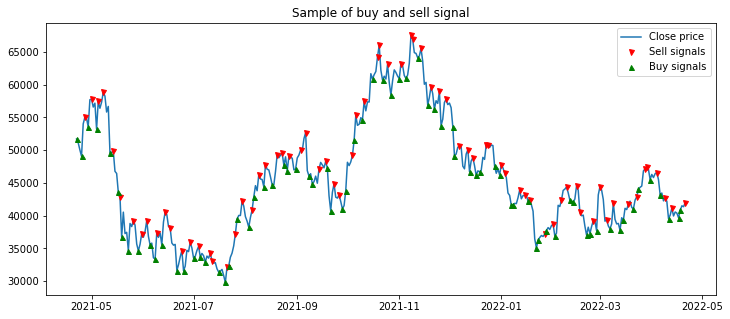

In [50]:
# plot buy sell signal
toplot_th = btc_df[-(365 * 1):]
plt.figure(figsize=(12, 5))
plt.plot(toplot_th["time"], toplot_th["Close"], label = "Close price")
plt.plot(toplot_th[toplot_th["target"] == 2]["time"], toplot_th[toplot_th["target"] == 2]["Close"], "v", color = "r", markersize = 5, label = "Sell signals")
plt.plot(toplot_th[toplot_th["target"] == 1]["time"], toplot_th[toplot_th["target"] == 1]["Close"], "^", color = "g", markersize = 5, label = "Buy signals")
plt.legend()
plt.title("Sample of buy and sell signal")
plt.show()

In [18]:
# # plot buy sell signal
# toplot_hh = btc_hourly_df[-(365 * 1):]
# plt.figure(figsize=(12, 5))
# plt.plot(toplot_hh["time"], toplot_hh["Close"], label = "Close price")
# plt.plot(toplot_hh[toplot_hh["target"] == 2]["time"], toplot_hh[toplot_hh["target"] == 2]["Close"], "v", color = "r", markersize = 5, label = "Sell signals")
# plt.plot(toplot_hh[toplot_hh["target"] == 1]["time"], toplot_hh[toplot_hh["target"] == 1]["Close"], "^", color = "g", markersize = 5, label = "Buy signals")
# plt.legend()
# plt.title("Sample of buy and sell signal")
# plt.show()

## **Split into train and test**

In [24]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [51]:
# attributes= btc_df.columns.tolist().remove('mytarget')
X = btc_df.drop(columns=['time', 'target', 'year'])
# X = btc_df.drop(columns=['time', 'target', 'future', 'year'])
y = btc_df["target"].astype(int)
X.head()

Open     High      Low    Close      Volume  day  month  dayofweek  \
49  4208.59  4355.00  4110.00  4292.43  779.138638    5     10          3   
50  4318.99  4417.00  4292.00  4369.00  506.529176    6     10          4   
51  4369.00  4479.50  4312.56  4423.00  297.597500    7     10          5   
52  4425.00  4658.00  4425.00  4640.00  518.462004    8     10          6   
53  4640.00  4889.98  4550.00  4786.95  646.463145    9     10          0   

          RSI       MA5  ...     ma20_7        vol_8  close_8   high_8  \
49  55.260237  4313.900  ...  3883.5775   628.170966  4193.00  4249.94   
50  57.272370  4312.004  ...  3879.3715   849.785325  4174.50  4300.00   
51  58.683623  4320.604  ...  3891.7785  1602.309565  4174.69  4263.86   
52  63.850718  4386.604  ...  3900.2790   720.353183  4378.51  4380.00   
53  66.872146  4502.276  ...  3911.0930   726.963685  4378.48  4406.52   

      low_8   open_8      rsi_8     ma5_8    ma10_8     ma20_8  
49  3872.81  3882.36  54.556052  3887.224  3848.703  3888.9925  
50  4101.00  4192.11  54.117714  3966.124  3862.652  3883.5775  
51  3952.01  4178.98  54.121790  4069.058  3889.117  3879.3715  
52  4138.10  4175.00  58.392897  4160.610  3936.968  3891.7785  
53  4240.04  4378.49  58.392035  4259.836  4013.817  3900.2790  

[5 rows x 88 columns]

In [52]:
y.value_counts()

0    996
1    332
2    332
Name: target, dtype: int64

In [53]:
train_index = int(btc_df.shape[0] * 0.7)
# train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

In [54]:
# train_index_hour = int(btc_hourly_df.shape[0] * 0.7)
# X_hour = btc_hourly_df.drop(columns=['time', 'target', 'year'])
# y_hour = btc_hourly_df["target"].astype(int)
# X_hour_train, X_hour_test = X_hour[:train_index_hour], X_hour[train_index_hour:]
# y_hour_train, y_hour_test = y_hour[:train_index_hour], y_hour[train_index_hour:]

##### **RNN DF**

In [55]:
n = len(btc_df)
to_lstm = btc_df.copy()
train_df_lstm = to_lstm[0:int(n*0.7)]
val_df_lstm = to_lstm[int(n*0.7):int(n*0.9)]
test_df_lstm = to_lstm[int(n*0.9):]

In [24]:
# n_hour = len(btc_hourly_df)
# h_train_df_lstm = btc_hourly_df[0:int(n_hour*0.7)]
# h_val_df_lstm = btc_hourly_df[int(n_hour*0.7):int(n_hour*0.9)]
# h_test_df_lstm = btc_hourly_df[int(n_hour*0.9):]

## **Normalized or Standardize data**

In [25]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [26]:
# scaler = StandardScaler()

# **Exploratory Data Analysis**

Explore common statistic and data behavior

## **Explore overall BTC-USD Price**

In [27]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [22]:
btc_df.describe()

Open          High           Low         Close         Volume  \
count   3776.000000   3776.000000   3776.000000   3776.000000    3776.000000   
mean    8372.845712   8620.361872   8087.640511   8383.347945    9196.544652   
std    14689.569657  15111.626577  14188.776967  14697.936177    9805.878648   
min        2.370000      2.370000      2.250000      2.250000       0.250000   
25%      260.885000    266.515000    254.040000    261.357500    3292.308601   
50%      918.310000    955.680000    890.205000    919.595000    6563.477935   
75%     8838.565000   9092.297500   8578.682500   8844.980000   11821.608877   
max    67547.490000  69000.000000  66250.000000  67559.000000  137064.000000   

               day        month         year    dayofweek          RSI  ...  \
count  3776.000000  3776.000000  3776.000000  3776.000000  3776.000000  ...   
mean     15.728284     6.512447  2016.518273     2.999735    54.538037  ...   
std       8.808443     3.505584     2.998840     2.000596    14.694336  ...   
min       1.000000     1.000000  2011.000000     0.000000     9.632983  ...   
25%       8.000000     3.000000  2014.000000     1.000000    44.232045  ...   
50%      16.000000     7.000000  2017.000000     3.000000    52.875797  ...   
75%      23.000000    10.000000  2019.000000     5.000000    63.901474  ...   
max      31.000000    12.000000  2022.000000     6.000000    97.088945  ...   

           close_15       high_15        low_15       open_15       rsi_15  \
count   3776.000000   3776.000000   3776.000000   3776.000000  3776.000000   
mean    8223.481684   8455.176549   7933.781539   8213.569905    54.457723   
std    14568.086100  14976.396150  14064.319843  14560.749021    14.775709   
min        2.240000      2.270000      2.220000      2.220000     9.632983   
25%      254.527500    259.332500    247.857500    254.415000    44.134173   
50%      898.505000    919.245000    858.965000    896.955000    52.793190   
75%     8758.430000   8987.402500   8504.677500   8758.437500    63.901474   
max    67559.000000  69000.000000  66250.000000  67547.490000    97.088945   

             ma5_15       ma10_15       ma20_15        future       target  
count   3776.000000   3776.000000   3776.000000   3776.000000  3776.000000  
mean    8203.546067   8177.248356   8121.484601   8434.569224     0.323093  
std    14541.893757  14507.978905  14431.513106  14736.024291     0.627795  
min        2.428000      2.604000      2.774500      2.250000     0.000000  
25%      253.050500    251.082500    251.715875    262.942500     0.000000  
50%      890.998000    880.260000    878.042750    939.170000     0.000000  
75%     8734.994000   8678.622750   8769.971625   8892.920000     0.000000  
max    65681.178000  64678.181000  63135.647000  67559.000000     2.000000  

[8 rows x 154 columns]

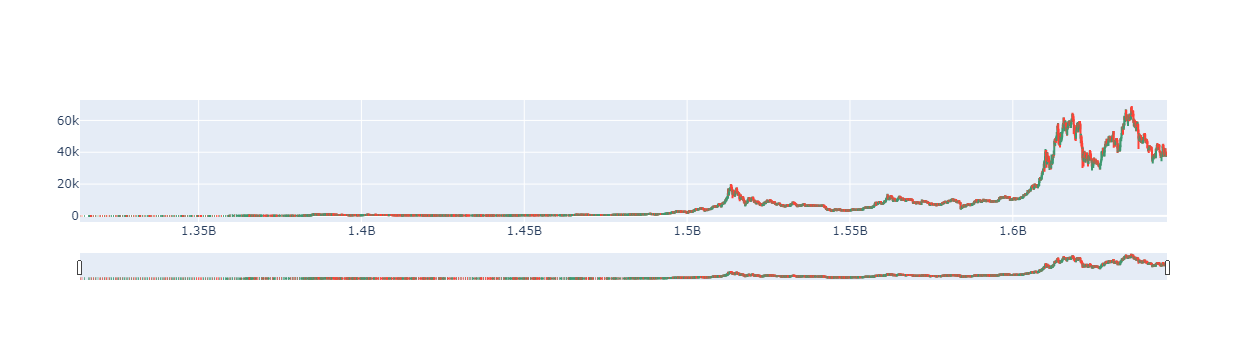

In [9]:
fig = go.Figure(data=[go.Candlestick(x=btc_df['time'],
                open=btc_df['Open'],
                high=btc_df['High'],
                low=btc_df['Low'],
                close=btc_df['Close'])])

fig.show()

## **Explore Close Price Group by Years**

In [10]:
years = btc_df['year'].unique()
price_year = {}
date_year = {}
plt_title = []
for i in years:
    price_year[f'{i}'] = btc_df[btc_df['year'] == i]['Close'].tolist()
    date_year[f'{i}'] = btc_df[btc_df['year'] == i]['time'].tolist()
    plt_title.append(f'BTC-USD {i} Price')

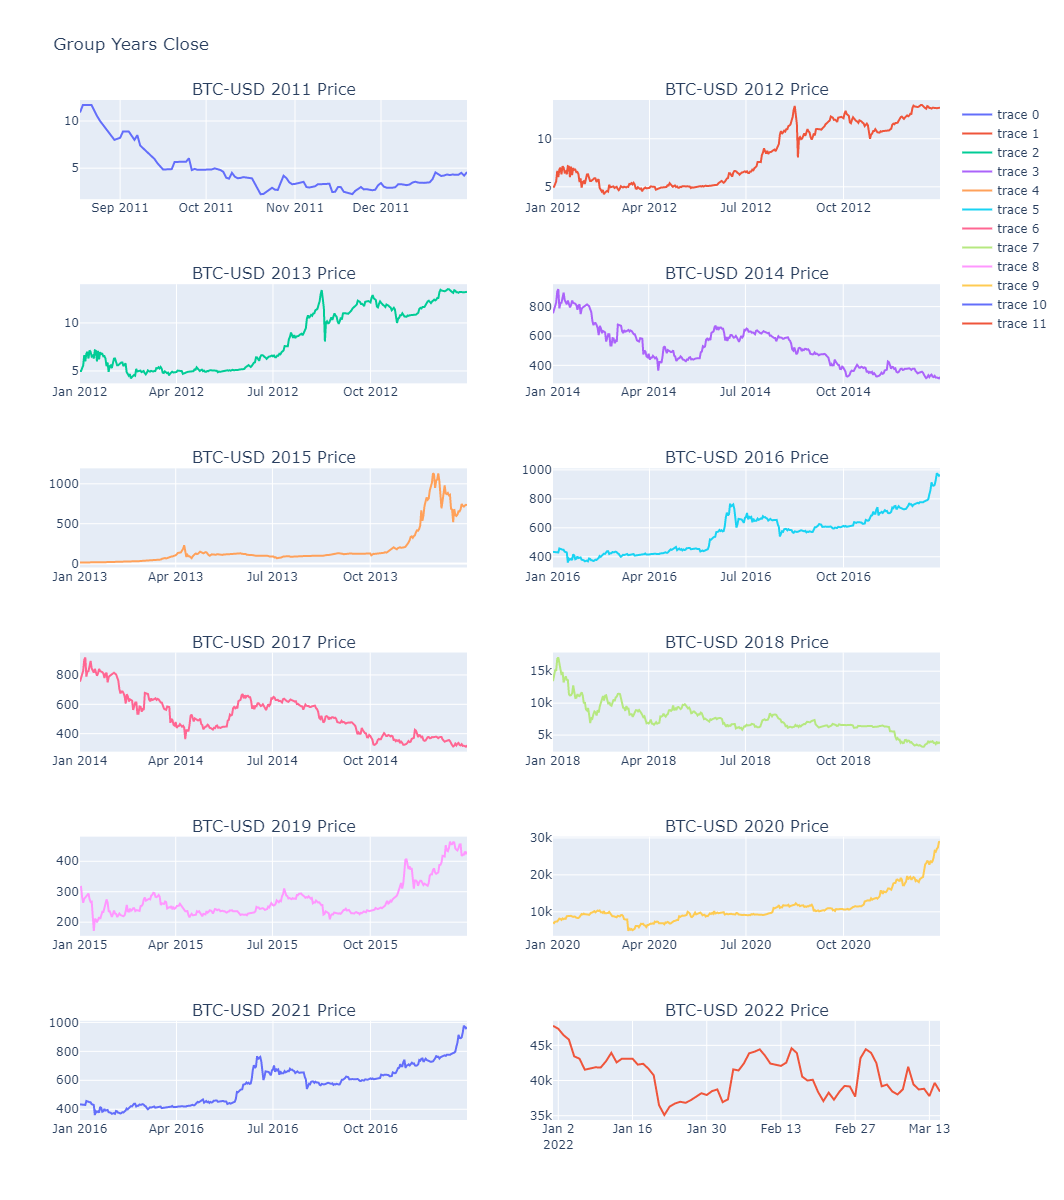

In [68]:
fig = make_subplots(rows=6, cols=2,subplot_titles=plt_title)

for i in range(1, 7):
    for j in range(1, 3):
        year_index = (i * j) - 1
        fig.append_trace(go.Scatter(
            x = date_year[f'{years[year_index]}'],
            y = price_year[f'{years[year_index]}']),
            row = i, col = j
        )

fig.update_layout(height=1200, width=1200, title_text="Group Years Close")
fig.show()

## **Percent Changes Per Year**

In [18]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(btc_df["close"], model='multiplicative', period=10)
# plt.figure(figsize=(20, 150))
# result.plot()
# plt.show()

# **Modeling and Evaluation**

Time-series classification models 
- XGBoost
    - General Parameters: Guide the overall functioning
    - Booster Parameters: Guide the individual booster (tree/regression) at each step
    - Learning Task Parameters: Guide the optimization performed
- LSTM: Long Short-term Memory
- GRU: Gated Recurrent Unit

In [38]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, GRU
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

from backtesting import Backtest, Strategy
# from backtesting.lib import crossover
clear_output()

In [29]:
train_performance = {}
test_performance = {}
bt_test_period = {}
walk_forward_result = {}

## **XGBoost**

In [30]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric = "auc")
xgb_model.fit(X_train, y_train)
pred_train = xgb_model.predict(X_train)
pred_test = xgb_model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

C:\Users\pond\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 54.8899%


In [24]:
# hourly training test
xgb_hourly = XGBClassifier(use_label_encoder=False, eval_metric = "auc")
xgb_hourly.fit(X_hour_train, y_hour_train)
pred_htrain = xgb_hourly.predict(X_hour_train)
pred_htest = xgb_hourly.predict(X_hour_test)
acc_train = accuracy_score(y_hour_train, pred_htrain)
acc_test = accuracy_score(y_hour_test, pred_htest)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

NameError: name 'X_hour_train' is not defined

In [119]:
print(classification_report(y_test, pred_test, zero_division=True))

              precision    recall  f1-score   support

           0       0.61      0.88      0.72       298
           1       0.65      0.15      0.24       100
           2       0.28      0.12      0.17       100

    accuracy                           0.58       498
   macro avg       0.51      0.38      0.38       498
weighted avg       0.55      0.58      0.51       498



In [120]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score

In [121]:
# xgboost_cv = cross_val_score(model, X_train, y_train, cv = test, scoring='f1_macro')

In [123]:
# xgboost_cv

#### **Tuning**

In [153]:
# import tscv

In [25]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import cross_val_score

In [27]:
xgboost_param = {
    'colsample_bytree': Real(0, 1 ,"uniform"),
    'gamma': Real(0, 10, "uniform"),
    'max_depth': Integer(4, 12),
    'lambda': Real(0, 1, "uniform"),
    'alpha': Real(0, 1, "uniform"),
    'eta': Real(0.01, 1, "uniform"),
    'n_estimators': Integer(20, 200)
    # 'max_leaves': []
}
clear_output()

In [29]:
tss = TimeSeriesSplit(n_splits=10)
xgb_opt = BayesSearchCV(XGBClassifier(use_label_encoder=False, eval_metric = "auc"),
                    search_spaces=xgboost_param,
                    cv=tss,
                    n_iter=10,
                    random_state=0,
                   scoring = "f1_macro")

In [30]:
xgb_opt.fit(X_train, y_train)

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, eval_metric='auc',
                                      gamma=None, gpu_id=None,
                                      importance_type='gain',
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=N...
                             'eta': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'gamma': Real(low=0, high=10, prior='uniform', transform='normalize'),
                             'lambda': Real(low=0, high=1, prior='uniform', transform='normalize'),
            

In [31]:
xgb_opt.best_params_

OrderedDict([('alpha', 0.5104890464184844),
             ('colsample_bytree', 0.5269790313150186),
             ('eta', 0.7245595844061744),
             ('gamma', 0.2729496131386156),
             ('lambda', 0.05272574702679923),
             ('max_depth', 6),
             ('n_estimators', 44)])

In [32]:
xgb_opt.best_params_['alpha']

0.5104890464184844

In [33]:
# train full model with optimized hyperparameter agian 
xgb_tuned = XGBClassifier(use_label_encoder=False, eval_metric = "auc",
                            reg_alpha = xgb_opt.best_params_['alpha'],
                            reg_lambda = xgb_opt.best_params_['lambda'],
                            colsample_bytree = xgb_opt.best_params_['colsample_bytree'],
                            learning_rate = xgb_opt.best_params_['eta'],
                            gamma = xgb_opt.best_params_['gamma'],
                            max_depth = xgb_opt.best_params_['max_depth'],
                            n_estimators = xgb_opt.best_params_['n_estimators']
)

In [34]:
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5269790313150186,
              eval_metric='auc', gamma=0.2729496131386156, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.7245595844061744, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=44, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=0,
              reg_alpha=0.5104890464184844, reg_lambda=0.05272574702679923,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [35]:
xgb_test_pred = xgb_tuned.predict(X_test)
xgb_train_pred = xgb_tuned.predict(X_train)
print(classification_report(y_test, xgb_test_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70       681
           1       0.43      0.20      0.27       227
           2       0.35      0.23      0.28       227

    accuracy                           0.57      1135
   macro avg       0.47      0.41      0.42      1135
weighted avg       0.53      0.57      0.53      1135



#### **Collect Result**

In [36]:
test_performance["XGBoost"] = {
    'precision': precision_score(y_test, xgb_test_pred, average="macro"),
    'recall': recall_score(y_test, xgb_test_pred, average="macro"),
    'f1-score': f1_score(y_test, xgb_test_pred, average="macro"),
    'roc-auc': roc_auc_score(y_test, xgb_tuned.predict_proba(X_test), multi_class='ovr', average='macro'),
    'accuracy': accuracy_score(y_test, xgb_test_pred)
}

In [37]:
train_performance["XGBoost"] = {
    'precision': precision_score(y_train, xgb_train_pred, average="macro"),
    'recall': recall_score(y_train, xgb_train_pred, average="macro"),
    'f1-score': f1_score(y_train, xgb_train_pred, average="macro"),
    'roc-auc': roc_auc_score(y_train, xgb_model.predict_proba(X_train), multi_class='ovr', average='macro'),
    'accuracy': accuracy_score(y_train, xgb_train_pred)
}

### **Train Once Method**

In [31]:
N_TRAIN = train_index

def get_X(features):
    """Return model design matrix X"""
    # feature = features.drop(columns=['target', 'future', 'year'])
    features = features.drop(columns=['target'])
    # features[features.columns] = scaler.transform(features)
    return features

# def get_X(features):
#     features = features.drop(columns=['target'])
#     features = np.array(features).reshape(features.shape[0], 1, features.shape[1])
#     return features

def get_y(data):
    return data["target"].astype(int)


def get_Xy():
    """Return (X, y) cleaned of NaN values, used to have parameter df"""
    # X = df.drop(columns=['target'])
    # X[X.columns] = scaler.transform(X)
    # X = get_X(df)
    # y = df["target"].astype(int)
    # X = X_train 
    # y = y_train
    # train_index = int(0.8 * len(X))
    X_train, X_test = X[:N_TRAIN], X[N_TRAIN:]
    y_train, y_test = y[:N_TRAIN], y[N_TRAIN:]
    return X_train, y_train

In [32]:
class MLTrainOnceStrategy(Strategy):
    price_delta = .3 # 15%

    def init(self):        
        # Init our model, a kNN classifier
        
        # self.clf = model
        self.clf = XGBClassifier(use_label_encoder=False, eval_metric = "auc")
        
        # self.clf = KNeighborsClassifier(weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
        
        # Train the classifier in advance on the first N_TRAIN examples
        # self.data.df = self.data.df[N_TRAIN:]
        df = self.data.df
        X, y = get_Xy()
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        # if len(self.data) < N_TRAIN:
        #     return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        # Forecast the next movement
        feature = get_X(self.data.df.iloc[-1:])
        # print(feature)
        # print(self.clf.predict(X))
        forecast = self.clf.predict(feature)
        # forecast = self.clf.predict(feature)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
    
        upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, sl=lower)
            # self.buy(size=.1, tp=upper, sl=lower)
        elif forecast == 2 and not self.position.is_short:
            self.sell(size=.2, sl=upper)
            # self.sell(size=.1, tp=lower, sl=upper)


In [40]:
data = btc_df.set_index("time").drop(columns=['year'])
# data[N_TRAIN:].head()
print(data[train_index:].shape[0], X_test.shape[0])

1135 1135


In [41]:
bt = Backtest(data[train_index:], MLTrainOnceStrategy, 
              cash= 1000000,
              commission=.0002)
stats = bt.run()
bt_test_period["XGBoost"] = stats
stats

Start                     2019-02-05 00:00:00
End                       2022-03-15 00:00:00
Duration                   1134 days 00:00:00
Exposure Time [%]                   95.418502
Equity Final [$]                868831.089236
Equity Peak [$]                1098565.130518
Return [%]                         -13.116891
Buy & Hold Return [%]              1019.71446
Return (Ann.) [%]                   -4.421003
Volatility (Ann.) [%]                9.858933
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -28.652587
Avg. Drawdown [%]                    -2.99396
Max. Drawdown Duration      699 days 00:00:00
Avg. Drawdown Duration       62 days 00:00:00
# Trades                                  125
Win Rate [%]                             57.6
Best Trade [%]                      52.207319
Worst Trade [%]                    -30.067036
Avg. Trade [%]                    

In [394]:
bt.plot()

Session output file 'MLTrainOnceStrategy.html' already exists, will be overwritten.


Row(id='4319', ...)

### **Walk forward Analysis**

In [57]:
# run walk forward analysis separately to collect all of the backtesting performance of out-of-sample set of data

In [34]:
# TimeSeriesSplit(n_splits=5)
# for t1, t2 in TimeSeriesSplit(n_splits=5).split(X):
#     # print(X.values[t1])
#     tmp = X.values[t1]
#     tmp2 = tmp[int(tmp.shape[0] * 0.7):]
#     print(tmp.shape)
#     print(tmp2.shape)

**DataFrame Parameters to fix**

In [56]:
def get_X(data):
    """Return model design matrix X"""
    return data.drop(columns = ["target"]).values

def get_y(data):
    """Return dependent variable y"""
    y = data["target"].astype("int")
    return y

def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    return X, y

In [57]:
xgboost_param = {
    'colsample_bytree': Real(0, 1 ,"uniform"),
    'gamma': Real(0, 10, "uniform"),
    'max_depth': Integer(4, 12),
    'lambda': Real(0, 1, "uniform"),
    'alpha': Real(0, 1, "uniform"),
    'eta': Real(0.01, 1, "uniform"),
    'n_estimators': Integer(20, 200)
    # 'max_leaves': []
}
clear_output()

In [60]:
def walkforward_validation(X, y):
    result = {
        "start": [],
        "end": [],
        "return": [],
        "ann_gain": [],
        "sharpe ratio": [],
        "buynhold": [],
        "final equity": [],
        "maxdrawdown": [],
        "numtrade": [],
        "winrate": [],
        "avgtrade": [],
        "acc_train": [],
        "acc_test": [],
        'precision': [],
        'recall': [],
        'f1-score': [],
        'roc-auc': [],
    }
    
    tss = TimeSeriesSplit(n_splits=5)
    
    for train_index, test_index in tss.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_temp = X.copy().values
        y_temp = y.copy().values
        # separate into train, validation and test
        X_train, X_test = X_temp[train_index], X_temp[test_index]
        y_train, y_test = y_temp[train_index], y_temp[test_index]

        print("last train :", train_index[-1], "last test:", test_index[-1])
        # print(type(test_index.tolist()))

        tss = TimeSeriesSplit(n_splits=3)
        xgb_opt = BayesSearchCV(XGBClassifier(use_label_encoder=False, eval_metric = "auc"),
                            search_spaces=xgboost_param,
                            cv=tss,
                            n_iter= 5,
                            random_state=0,
                            scoring = "f1_macro")
        xgb_opt.fit(X_train, y_train)
        model = xgb_opt.best_estimator_
        
        # model = XGBClassifier(use_label_encoder=False, eval_metric = "auc",
        #                      reg_alpha = xgb_opt.best_params_['alpha'],
        #                     reg_lambda = xgb_opt.best_params_['lambda'],
        #                     colsample_bytree = xgb_opt.best_params_['colsample_bytree'],
        #                     learning_rate = xgb_opt.best_params_['eta'],
        #                     gamma = xgb_opt.best_params_['gamma'],
        #                     max_depth = xgb_opt.best_params_['max_depth'],
        #                     n_estimators = xgb_opt.best_params_['n_estimators'])

        # model.fit(X_train, y_train)

        # Backtest with each fold
        class Walkforward(Strategy):
            price_delta = .3
            def init(self):        
                # self.clf = 

                self.clf = model

                # Plot y for inspection
                self.I(get_y, self.data.df, name='y_true')

                # Prepare empty, all-NaN forecast indicator
                self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

            def next(self):

                high, low, close = self.data.High, self.data.Low, self.data.Close
                current_time = self.data.index[-1]

                # Now that the model is fitted, 
                # proceed the same as in MLTrainOnceStrategy
                # super().next()

                feature = get_X(self.data.df.iloc[-1:])
                forecast = self.clf.predict(feature)[0]

                # Update the plotted "forecast" indicator
                self.forecasts[-1] = forecast

                upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

                if forecast == 1 and not self.position.is_long:
                    self.buy(size=.2, sl=lower)
                    # self.buy(size=.1, tp=upper, sl=lower)
                elif forecast == 2 and not self.position.is_short:
                    self.sell(size=.2, sl=upper)

                super().next()

        data_totest = btc_df.iloc[test_index.tolist(), :].set_index("time").drop(columns=['year'])
        bt_walkforward = Backtest(data_totest, Walkforward, 
                  cash= 1000000,
                  commission=.0002)
        stats_walk = bt_walkforward.run()

        test_pred = model.predict(X_test)
        
        result['return'].append(stats_walk["Return [%]"])
        result['ann_gain'].append(stats_walk["Return (Ann.) [%]"])
        result['sharpe ratio'].append(stats_walk["Sharpe Ratio"])
        result['start'].append(stats_walk["Start"])
        result['end'].append(stats_walk["End"])
        result['buynhold'].append(stats_walk["Buy & Hold Return [%]"])
        result['final equity'].append(stats_walk["Equity Final [$]"])
        result['acc_train'].append(accuracy_score(y_train, model.predict(X_train)))
        result['acc_test'].append(accuracy_score(y_test, model.predict(X_test)))
        result["maxdrawdown"].append(stats_walk["Max. Drawdown [%]"])
        result["numtrade"].append(stats_walk["# Trades"])
        result["winrate"].append(stats_walk["Win Rate [%]"])
        result["avgtrade"].append(stats_walk["Avg. Trade [%]"])
        result['precision'].append(precision_score(y_test, test_pred, average="macro"))
        result['recall'].append(recall_score(y_test, test_pred, average="macro"))
        result['f1-score'].append(f1_score(y_test, test_pred, average="macro"))
        result['roc-auc'].append(roc_auc_score(y_test, model.predict_proba (X_test), multi_class='ovr', average='macro'))
        
    return result

In [61]:
result = walkforward_validation(X, y)

last train : 279 last test: 555
last train : 555 last test: 831
last train : 831 last test: 1107
last train : 1107 last test: 1383
last train : 1383 last test: 1659


In [62]:
result_xgb_df = pd.DataFrame(result)
result_xgb_df

start        end     return   ann_gain  sharpe ratio    buynhold  \
0 2018-07-12 2019-04-13  -3.625493  -4.766324      0.000000  -19.283841   
1 2019-04-14 2020-01-14  -5.691041  -7.456227      0.000000   71.691579   
2 2020-01-15 2020-10-16   1.804030   2.392676      0.240412   28.316448   
3 2020-10-17 2021-07-19 -14.750570 -19.026670      0.000000  171.471013   
4 2021-07-20 2022-04-21  -2.508795  -3.304293      0.000000   40.884582   

   final equity  maxdrawdown  numtrade    winrate  avgtrade  acc_train  \
0  9.637451e+05    -7.254149        26  57.692308 -4.380258   0.846429   
1  9.430896e+05    -9.798781        22  59.090909 -1.389485   0.859712   
2  1.018040e+06    -4.826841        15  60.000000  0.005499   0.861779   
3  8.524943e+05   -20.843341        35  48.571429 -4.993399   0.862816   
4  9.749121e+05    -9.976262        21  52.380952 -2.031383   0.816474   

   acc_test  precision    recall  f1-score   roc-auc  
0  0.431159   0.393912  0.411760  0.392909  0.572985  
1  0.561594   0.444470  0.392296  0.390427  0.611129  
2  0.565217   0.447552  0.394661  0.394039  0.627143  
3  0.485507   0.435329  0.415250  0.410713  0.637549  
4  0.601449   0.566269  0.458914  0.475052  0.716718

In [63]:
walk_forward_result["XGBoost"] = result_xgb_df

### **Walk forward Training Backtest**

In [48]:
N_TRAIN = btc_df.shape[0] - (365 * 1)
class MLWalkForwardStrategy(Strategy):
    price_delta = .3 # 15%

    def init(self):        
        # Init the XGBoost model and compile at the initial of class
        self.clf = XGBClassifier(use_label_encoder=False, 
                             colsample_bytree = 1,
                             max_depth = 6,
                             gamma = 2.74,
                             reg_lambda = 0.19,
                             reg_alpha = 0.2,
                             eta = 0.363,
                             n_estimators = 166,
                             eval_metric = "auc")
        
        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)

        # df = self.data.df
        # X, y = get_Xy()
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the cold start period with too few values available
        if len(self.data) < N_TRAIN:
            return super().next()

        # Re-train the model only every 20 iterations.
        # Since 20 << N_TRAIN, we don't lose much in terms of
        # "recent training examples", but the speed-up is significant!
        if len(self.data) % 30 == 0: # this threshold is size of validation set of expanding window validation
            df = self.data.df[-N_TRAIN:]
            X, y = get_clean_Xy(df)
            self.clf.fit(X, y)
            # print(len(self.data))
            # print(self.clf.score(get_X(self.data.df.iloc[N_TRAIN:]), get_y(self.data.df.iloc[N_TRAIN:])))
            # return super().next()

        # Retrain on last N_TRAIN values
        
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Now that the model is fitted, 
        # proceed the same as in MLTrainOnceStrategy
        # super().next()
        
        feature = get_X(self.data.df.iloc[-1:])
        # forecast = self.clf.predict(feature)
        # print(self.clf.score(get_X(self.data.df.iloc[N_TRAIN:]), get_y(self.data.df.iloc[N_TRAIN:])))
        forecast = self.clf.predict(feature)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
    
        upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, sl=lower)
            # self.buy(size=.1, tp=upper, sl=lower)
        elif forecast == 2 and not self.position.is_short:
            self.sell(size=.2, sl=upper)
        
        super().next()

In [49]:
def buy_and_hold(df, start, stop):
    # start = [int(i) for i in start.split("-")]
    # start = pd.Timestamp(year=start[0], month=start[1], day=start[2], hour=0)
    start_close = df.loc[start, "Close"]
    
    # stop = [int(i) for i in stop.split("-")]
    # stop = pd.Timestamp(year=stop[0], month=stop[1], day=stop[2], hour=0)
    stop_close = df.loc[stop, "Close"]
    
    pct_chage = ((stop_close - start_close) * 100) / start_close
    print(f"Buy and Hold Return {pct_chage:.3f}%")
    # buy = df[]

In [59]:
data = btc_df.set_index("time").drop(columns=['year'])
data[N_TRAIN:].head()
print(data[train_index:].shape[0], X_test.shape[0])

365 365


In [60]:
# buy and hold return calculation from data
end_date = pd.Timestamp("2022-03-07")
buy_and_hold(data, end_date - (pd.Timedelta("365 days") * 2), end_date)

Buy and Hold Return 327.443%


In [57]:
bt_walkforward = Backtest(data, MLWalkForwardStrategy, 
              cash= 1000000,
              commission=.0002)
stats_walk = bt_walkforward.run()
stats_walk

Start                     2011-10-28 00:00:00
End                       2022-03-10 00:00:00
Duration                   3786 days 00:00:00
Exposure Time [%]                    7.494703
Equity Final [$]                949117.393984
Equity Peak [$]                1021841.293612
Return [%]                          -5.088261
Buy & Hold Return [%]           939053.571429
Return (Ann.) [%]                    -0.50353
Volatility (Ann.) [%]                 3.11506
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.725224
Avg. Drawdown [%]                   -3.575537
Max. Drawdown Duration      306 days 00:00:00
Avg. Drawdown Duration       80 days 00:00:00
# Trades                                    3
Win Rate [%]                        33.333333
Best Trade [%]                      35.947786
Worst Trade [%]                    -30.027576
Avg. Trade [%]                    

In [58]:
bt_walkforward.plot()

Row(id='2476', ...)

### **Strategy Optimization (Tuning within Expanding window backtest)**

Optimizing(tuning) parameter of model with backtest optimization of the signal classification model **Take time to run**

In [68]:
def get_Xy_tuning():
    return X_hour_train, y_hour_train

In [69]:
class MLTuningStrategy(Strategy):
    price_delta = .3 # 15%
    colsample_bytree = 1
    gamma = 0.1
    max_depth = 6
    lamb = 0.1
    alpha = 0
    learning_rate = 0.1
    n_estimators = 50
    
    def init(self):        
        # Init our model, a kNN classifier
        
        # self.clf = model
        self.clf = XGBClassifier(use_label_encoder=False, 
                                 max_depth = self.max_depth,
                                 gamma = self.gamma,
                                 reg_lambda = self.lamb,
                                 reg_alpha = self.alpha,
                                 eta = self.learning_rate,
                                 n_estimators = self.n_estimators,
                                 eval_metric = "auc")
        
        
        # Train the classifier in advance on the first N_TRAIN examples
        # self.data.df = self.data.df[N_TRAIN:]
        df = self.data.df
        X, y = get_Xy_tuning()
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        # if len(self.data) < N_TRAIN:
        #     return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        # Forecast the next movement
        feature = get_X(self.data.df.iloc[-1:])
        # print(feature)
        # print(self.clf.predict(X))
        forecast = self.clf.predict(feature)
        # forecast = self.clf.predict(feature)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
    
        upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, sl=lower)
            # self.buy(size=.1, tp=upper, sl=lower)
        elif forecast == 2 and not self.position.is_short:
            self.sell(size=.2, sl=upper)
            # self.sell(size=.1, tp=lower, sl=upper)
        
        super().next()

In [71]:
# xgboost_param = {
#     'colsample_bytree': [1, 0.8, 0.5],
#     'gamma': [0, 0.1, 1],
#     'max_depth': [4, 6, 8, 10],
#     'lambda': [0, 0.1, 0.5, 1],
#     'alpha': [0, 0.1, 0.5, 1],
#     'learning_rate': [0.001, 0.01, 0.3, 0.7],
#     'n_estimators': [50, 100, 200],
#     # 'max_leaves': []
# }

xgboost_param = {
    'colsample_bytree': [0.5, 1],
    'gamma': [0, 1],
    'max_depth': [4, 10],
    'lambda': [0, 1],
    'alpha': [0, 1],
    'learning_rate': [0.01, 1],
    'n_estimators': [50, 200],
    # 'max_leaves': []
}

In [76]:
data_tuning = btc_hourly_df.set_index("time").drop(columns=['year'])
# data[N_TRAIN:].head()
print(data_tuning[train_index_hour:].shape[0], X_hour_test.shape[0])

12081 12081


In [77]:
%%time

tuning_bt = Backtest(data_tuning, MLTuningStrategy, cash= 1000000, commission=.002)

stats, heatmap = tuning_bt.optimize(
    colsample_bytree = xgboost_param["colsample_bytree"],
    gamma = xgboost_param["gamma"],
    max_depth = xgboost_param["max_depth"],
    lamb = xgboost_param["lambda"],
    alpha = xgboost_param["alpha"],
    learning_rate = xgboost_param["learning_rate"],
    n_estimators = xgboost_param["n_estimators"],
    maximize = "Equity Final [$]",
    method = "skopt",
    max_tries= 2,
    random_state=0,
    return_heatmap=True)

Wall time: 14min


In [78]:
heatmap.sort_values()

colsample_bytree  gamma  max_depth  lamb  alpha  learning_rate  n_estimators
0.681201          0      5          1     0      0.286564       53              2.563969e+06
0.952262          1      8          0     1      0.990479       197             7.269975e+08
Name: Equity Final [$], dtype: float64

In [79]:
stats

Start                     2017-08-19 05:00:00
End                       2022-03-29 06:00:00
Duration                   1683 days 01:00:00
Exposure Time [%]                   99.821198
Equity Final [$]             726997511.871578
Equity Peak [$]             1033386439.953198
Return [%]                       72599.751187
Buy & Hold Return [%]             1068.808192
Return (Ann.) [%]                  316.588491
Volatility (Ann.) [%]                63.17521
Sharpe Ratio                         5.011277
Sortino Ratio                       66.842077
Calmar Ratio                        10.205165
Max. Drawdown [%]                  -31.022378
Avg. Drawdown [%]                   -0.066016
Max. Drawdown Duration      475 days 13:00:00
Avg. Drawdown Duration        0 days 09:00:00
# Trades                                 9090
Win Rate [%]                         76.69967
Best Trade [%]                      33.486901
Worst Trade [%]                     -22.68612
Avg. Trade [%]                    

In [176]:
tuning_bt.plot()

Row(id='5271', ...)

## **Long short-term memory (LSTM)**

In [70]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [71]:
minmax_scaler = MinMaxScaler(feature_range = (0, 1))
scaler = StandardScaler()

In [72]:
train_mean = np.log1p(train_df_lstm.drop(columns = ["time", "year", "target"])).mean()
train_std = np.log1p(train_df_lstm.drop(columns = ["time", "year", "target"])).std()

In [73]:
# train_mean_h = np.log1p(h_train_df_lstm.drop(columns = ["time", "year", "target"])).mean()
# train_std_h = np.log1p(h_train_df_lstm.drop(columns = ["time", "year", "target"])).std()

In [74]:
# retrun just x and y, so that trian, validation, test can be passes in
def lstm_preprocess(df, seq_size, isTrainset = False):
    X_temp = np.log1p(df.drop(columns = ["time", "year", "target"]))
    y_temp = df["target"]

    X_temp = (X_temp - train_mean) / train_std

    x = []
    y = []
    # to sequence function
    for i in range(len(df) - seq_size):
        window = X_temp[i:(i+ seq_size)]
        after_window = y_temp[y_temp.index[i] + seq_size]
        x.append(window)
        y.append(after_window)
    
    
    y_temp = tf.keras.utils.to_categorical(np.array(y))
    x = np.array(x)

    return x, y_temp

In [75]:
X_train_lstm, y_train_lstm = lstm_preprocess(train_df_lstm, 9, True)
X_val_lstm, y_val_lstm = lstm_preprocess(val_df_lstm, 9, False)
X_test_lstm, y_test_lstm = lstm_preprocess(test_df_lstm, 9, False)

In [76]:
# X_train_lstm_h, y_train_lstm_h = lstm_preprocess(h_train_df_lstm, 24, True)
# X_val_lstm_h, y_val_lstm_h = lstm_preprocess(h_val_df_lstm, 24, False)
# X_test_lstm_h, y_test_lstm_h = lstm_preprocess(h_test_df_lstm, 24, False)

In [132]:
model = Sequential()
# model.add(LSTM(128, input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences =True))
model.add(LSTM(64, activation = "relu", input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences =True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

# model.add(LSTM(256, activation = "relu", return_sequences = True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(LSTM(128, activation = "relu", return_sequences = True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(LSTM(64, activation = "relu"))
model.add(Dropout(0.1))
model.add(BatchNormalization())


model.add(Dense(3,  activation = "softmax"))

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
# sgd_opt = tf.keras.optimizers.SGD(learning_rate = 0.01)

model.compile(loss = "categorical_crossentropy",
             optimizer = opt,
             metrics = ['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 9, 64)             39168     
                                                                 
 dropout_43 (Dropout)        (None, 9, 64)             0         
                                                                 
 batch_normalization_20 (Bat  (None, 9, 64)            256       
 chNormalization)                                                
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_21 (Bat  (None, 64)               256       
 chNormalization)                                    

In [133]:
NAME = f"LSTM${time.time()}"
tensorboard = TensorBoard(log_dir = f"logs_mini/{NAME}")

filepath = "RNN_Final-{epoch:02d}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, 
                                                      monitor = "val_acc", 
                                                      verbose = 1, 
                                                      save_best_only = True,
                                                     mode = "max"))

In [134]:
history = model.fit(
                    X_train_lstm,
                    y_train_lstm,
                    batch_size = 64,
                    epochs = 200,
                    validation_data = (X_val_lstm, y_val_lstm),
                    callbacks = [tensorboard],
                    verbose = 0
                   )

In [567]:
model.save

<bound method Model.save of <keras.engine.sequential.Sequential object at 0x00000251DBFE2400>>

In [135]:
model.evaluate(X_test_lstm, y_test_lstm)

5/5 [==============================] - 0s 6ms/step - loss: 7.5634 - accuracy: 0.5796


[7.563446998596191, 0.5796178579330444]

In [136]:
np.argmax(model.predict(X_test_lstm[-300:]), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0], dtype=int64)

In [361]:
y_pred_tmp = np.argmax(model.predict(X_test_lstm), axis=1)
print(classification_report(test_df_lstm["target"][-370:].values, y_pred_tmp, zero_division=True))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       222
           1       0.21      0.19      0.20        74
           2       0.19      0.28      0.23        74

    accuracy                           0.42       370
   macro avg       0.35      0.34      0.34       370
weighted avg       0.46      0.42      0.44       370



In [116]:
from sklearn.metrics import confusion_matrix

In [362]:
confusion_matrix(test_df_lstm["target"][-370:].values, y_pred_tmp, labels=[0, 1, 2])

array([[122,  35,  65],
       [ 34,  14,  26],
       [ 36,  17,  21]], dtype=int64)

In [337]:
# %load_ext tensorboard
# %tensorboard --logdir logs_mini

#### **Tuning**

In [118]:
import keras_tuner as kt

In [119]:
def build_lstm(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('layers_0', min_value=32, max_value=256, step=32), 
                   input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2]), 
                   return_sequences = True,
                   activation = "relu"))
    model.add(Dropout(hp.Float("dropout", 0.1, 0.2)))
    model.add(BatchNormalization())

    for _ in range(hp.Int("num_layer", 0, 2)):
        model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32), 
                       return_sequences = True,
                       activation = "relu"))
        model.add(Dropout(hp.Float("dropout", 0.1, 0.2)))
        model.add(BatchNormalization())

    model.add(LSTM(units=hp.Int('units_3', min_value=32, max_value=256, step=32), activation = "relu"))
    model.add(Dropout(hp.Float("dropout", 0.1, 0.2)))
    model.add(BatchNormalization())

    model.add(Dense(3,  activation = "softmax"))

    model.compile(loss = "categorical_crossentropy",
             optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
             metrics = ['accuracy'])

    return model

In [579]:
bayesian_opt = kt.BayesianOptimization(build_lstm,
                            objective="val_loss",
                            max_trials = 20,
                            project_name = "lstm_label1"
                           )

In [580]:
bayesian_opt.search(X_train_lstm, y_train_lstm, validation_data = (X_val_lstm, y_val_lstm), verbose = 1, batch_size = 64, epochs = 100
                    # class_weight = weight
                   )

Trial 9 Complete [00h 22m 14s]
val_loss: 0.9502078890800476

Best val_loss So Far: 0.9491833448410034
Total elapsed time: 01h 42m 21s

Search: Running Trial #10

Hyperparameter    |Value             |Best Value So Far 
units_1           |256               |256               
dropout           |0.1               |0.2               
num_layer         |2                 |2                 
units_3           |256               |256               
learning_rate     |0.001             |0.001             
units_2           |32                |32                

Epoch 1/100
42/42 [==============================] - 17s 215ms/step - loss: 1.2434 - accuracy: 0.4126 - val_loss: 0.9606 - val_accuracy: 0.5997
Epoch 2/100
42/42 [==============================] - 8s 186ms/step - loss: 1.1093 - accuracy: 0.5051 - val_loss: 0.9516 - val_accuracy: 0.5997
Epoch 3/100
42/42 [==============================] - 8s 193ms/step - loss: 1.0885 - accuracy: 0.5442 - val_loss: 0.9536 - val_accuracy: 0.5997
Epoch 4/

KeyboardInterrupt: 

In [363]:
# best_model_lstm = bayesian_opt.get_best_models()[0]
best_model_lstm = model

In [577]:
best_hp = bayesian_opt.get_best_hyperparameters()[0]
model_tuned = bayesian_opt.hypermodel.build(best_hp)

In [372]:
# going to be best_model instead of model
lstm_test_pred = np.argmax(best_model_lstm.predict(X_test_lstm), axis=1)
lstm_train_pred = np.argmax(best_model_lstm.predict(X_train_lstm), axis=1)
lstm_y_test = test_df_lstm["target"][-lstm_test_pred.shape[0]:].values
lstm_y_train = train_df_lstm["target"][-lstm_train_pred.shape[0]:].values
print(classification_report(lstm_y_test, lstm_test_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       222
           1       0.21      0.19      0.20        74
           2       0.19      0.28      0.23        74

    accuracy                           0.42       370
   macro avg       0.35      0.34      0.34       370
weighted avg       0.46      0.42      0.44       370



##### **Collect Result**

In [370]:
test_performance["LSTM"] = {
    'precision': precision_score(lstm_y_test, lstm_test_pred, average="macro"),
    'recall': recall_score(lstm_y_test, lstm_test_pred, average="macro"),
    'f1-score': f1_score(lstm_y_test, lstm_test_pred, average="macro"),
    'roc-auc': roc_auc_score(lstm_y_test, best_model_lstm.predict(X_test_lstm), multi_class='ovr', average='macro'),
    'accuracy': accuracy_score(lstm_y_test, lstm_test_pred)
}

In [374]:
train_performance["LSTM"] = {
    'precision': precision_score(lstm_y_train, lstm_train_pred, average="macro"),
    'recall': recall_score(lstm_y_train, lstm_train_pred, average="macro"),
    'f1-score': f1_score(lstm_y_train, lstm_train_pred, average="macro"),
    'roc-auc': roc_auc_score(lstm_y_train, best_model_lstm.predict(X_train_lstm), multi_class='ovr', average='macro'),
    'accuracy': accuracy_score(lstm_y_train, lstm_train_pred)
}

### **Train Once**

In [66]:
class LSTMTrainOnce(Strategy):
    price_delta = .3
    def init(self):        
        # self.clf = 

        # Train the classifier in advance on the first N_TRAIN examples
#                 df = self.data.df.iloc[:N_TRAIN]
#                 X, y = get_clean_Xy(df)
#                 self.clf.fit(X, y)
        # self.clf = model

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the cold start period with too few values available
        # if len(self.data) < N_TRAIN:
        #     return super().next()

        # if len(self.data) % 20 == 0: # this threshold is size of validation set of expanding window validation
        #     df = self.data.df[-N_TRAIN:]
        #     X, y = get_clean_Xy(df)
        #     self.clf.fit(X, y)
        # use train once for walking forward analysis

        # Retrain on last N_TRAIN values

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        if len(self.data.df) >= 9:
            # print(self.data.df[-9:-1])
            feature = get_X_lstm(self.data.df[-9:])
            forecast = np.argmax(model.predict(feature), axis = 1)[0]
            self.forecasts[-1] = forecast
        # Update the plotted "forecast" indicator
            

            upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

            if forecast == 1 and not self.position.is_long:
                self.buy(size=.2, sl=lower)
                # self.buy(size=.1, tp=upper, sl=lower)
            elif forecast == 2 and not self.position.is_short:
                self.sell(size=.2, sl=upper)

        super().next()

In [67]:
data = btc_df.set_index("time").drop(columns=['year'])
data[int(n*0.9):].head()
print(data[int(n*0.9):].shape[0], test_df_lstm.shape[0])

379 379


In [236]:
bt = Backtest(data[int(n*0.9):], LSTMTrainOnce, 
              cash= 1000000,
              commission=.0002)
stats = bt.run()
stats

Start                     2021-03-02 00:00:00
End                       2022-03-15 00:00:00
Duration                    378 days 00:00:00
Exposure Time [%]                   91.029024
Equity Final [$]                889162.132498
Equity Peak [$]                1009917.101248
Return [%]                         -11.083787
Buy & Hold Return [%]              -20.806553
Return (Ann.) [%]                  -10.697099
Volatility (Ann.) [%]                8.489398
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -13.339892
Avg. Drawdown [%]                   -6.758214
Max. Drawdown Duration      367 days 00:00:00
Avg. Drawdown Duration      185 days 00:00:00
# Trades                                   48
Win Rate [%]                            43.75
Best Trade [%]                      20.598873
Worst Trade [%]                    -30.084535
Avg. Trade [%]                    

In [88]:
bt.plot()

Row(id='2929', ...)

### **Walk Forward Analysis**

In [79]:
def get_X_lstm(data):
    """Return model design matrix X"""
    # X_train[-9:].values.reshape(1, 9, X_train[-9:].shape[1])
    data = data.drop(columns = ["target"])
    data = np.log1p(data)
    data = (data - train_mean) / train_std
    data = data.values.reshape(1, 9, data.shape[1])
    return data

def get_y_lstm(data):
    """Return dependent variable y"""
    y = tf.keras.utils.to_categorical(data["target"].astype("int").values)
    return y

def get_clean_Xy_lstm(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    return X, y

In [80]:
def lstm_preprocess_wfa(df, seq_size, mean, std, isTrainset = False):
    X_temp = np.log1p(df.drop(columns = ["time", "year", "target"]))
    y_temp = df["target"]

    X_temp = (X_temp - mean) / std

    x = []
    y = []
    # to sequence function
    for i in range(len(df) - seq_size):
        window = X_temp[i:(i+ seq_size)]
        after_window = y_temp[y_temp.index[i] + seq_size]
        x.append(window)
        y.append(after_window)
    
    
    y_temp = tf.keras.utils.to_categorical(np.array(y))
    x = np.array(x)

    return x, y_temp

In [141]:
def walkforward_validation_lstm(df):
    # the parameter X, y was used before
    result = {
        "start": [],
        "end": [],
        "return": [],
        "ann_gain": [],
        "sharpe ratio": [],
        "buynhold": [],
        "final equity": [],
        "maxdrawdown": [],
        "numtrade": [],
        "winrate": [],
        "avgtrade": [],
        "acc_train": [],
        "acc_test": [],
        'precision': [],
        'recall': [],
        'f1-score': [],
        'roc-auc': [],
    }
    X = df.drop(columns = ["target", "time", "year"])
    y = df["target"]
    
    tss = TimeSeriesSplit(n_splits=5)
    
    for train_index, test_index in tss.split(df):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        train_mean = np.log1p(train_df.drop(columns = ["target", "time", "year"])).mean()
        train_std = np.log1p(train_df.drop(columns = ["target", "time", "year"])).std()
        # separate validation set from train set
        index_train = int(train_df.shape[0] * 0.7)
        X_train, y_train = lstm_preprocess_wfa(train_df[:index_train], 9, train_mean, train_std)
        X_val, y_val = lstm_preprocess_wfa(train_df[index_train:], 9, train_mean, train_std)
        X_test, y_test = lstm_preprocess_wfa(test_df, 9, train_mean, train_std)
        print("last train :", train_index[-1], "last test:", test_index[-1])
        

        model = Sequential()
        model.add(LSTM(32, activation = "relu", input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences =True))
        # model.add(LSTM(32, input_shape = (None, 1), return_sequences =True))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(LSTM(32, activation = "relu"))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(3,  activation = "softmax"))

        opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

        model.compile(loss = "categorical_crossentropy",
                     optimizer = opt,
                     metrics = ['accuracy'])

        history = model.fit(X_train,
                            y_train,
                            batch_size = 64,
                            epochs = 200,
                            verbose=0,
                            validation_data = (X_val, y_val),
                    # callbacks = [tensorboard, checkpoint]
                    # callbacks = [tensorboard]
                   )

        # Backtest with each fold
        class Walkforward(Strategy):
            price_delta = .3
            def init(self):        
                # self.clf = 

                # Train the classifier in advance on the first N_TRAIN examples
#                 df = self.data.df.iloc[:N_TRAIN]
#                 X, y = get_clean_Xy(df)
#                 self.clf.fit(X, y)
                self.clf = model

                # Plot y for inspection
                self.I(get_y, self.data.df, name='y_true')

                # Prepare empty, all-NaN forecast indicator
                self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

            def next(self):

                high, low, close = self.data.High, self.data.Low, self.data.Close
                current_time = self.data.index[-1]

                # Now that the model is fitted, 
                # super().next()

                if len(self.data.df) >= 9:
                    # print(self.data.df[-9:-1])
                    feature = get_X_lstm(self.data.df[-9:])
                    forecast = np.argmax(model.predict(feature), axis = 1)[0]
                    self.forecasts[-1] = forecast
                    # Update the plotted "forecast" indicator
                    
                    upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)
                    if forecast == 1 and not self.position.is_long:
                        self.buy(size=.2, sl=lower)
                        # self.buy(size=.1, tp=upper, sl=lower)
                    elif forecast == 2 and not self.position.is_short:
                        self.sell(size=.2, sl=upper)

                super().next()

        data_totest = btc_df.iloc[test_index.tolist(), :].set_index("time").drop(columns=['year'])
        bt_walkforward = Backtest(data_totest, Walkforward, 
                  cash= 1000000,
                  commission=.0002)
        stats_walk = bt_walkforward.run()
        
        acc_train = model.evaluate(X_train, y_train)
        acc_test = model.evaluate(X_test, y_test)
        lstm_test_pred = np.argmax(model.predict(X_test), axis=1)
        lstm_y_test = test_df["target"][-lstm_test_pred.shape[0]:].values
        
        result['return'].append(stats_walk["Return [%]"])
        result['ann_gain'].append(stats_walk["Return (Ann.) [%]"])
        result['sharpe ratio'].append(stats_walk["Sharpe Ratio"])
        result['start'].append(stats_walk["Start"])
        result['end'].append(stats_walk["End"])
        result['buynhold'].append(stats_walk["Buy & Hold Return [%]"])
        result['final equity'].append(stats_walk["Equity Final [$]"])
        result["maxdrawdown"].append(stats_walk["Max. Drawdown [%]"])
        result["numtrade"].append(stats_walk["# Trades"])
        result["winrate"].append(stats_walk["Win Rate [%]"])
        result["avgtrade"].append(stats_walk["Avg. Trade [%]"])
        result['acc_train'].append(acc_train[1])
        result['acc_test'].append(acc_test[1])
        result['precision'].append(precision_score(lstm_y_test, lstm_test_pred, average="macro", zero_division=True))
        result['recall'].append(recall_score(lstm_y_test, lstm_test_pred, average="macro"))
        result['f1-score'].append(f1_score(lstm_y_test, lstm_test_pred, average="macro"))
        result['roc-auc'].append(roc_auc_score(lstm_y_test, model.predict(X_test), multi_class='ovr', average='macro'))
        
    return result

In [142]:
result_lstm = walkforward_validation_lstm(btc_df)

last train : 279 last test: 555
9/9 [==============================] - 0s 4ms/step - loss: 2.4634 - accuracy: 0.2959
last train : 555 last test: 831
9/9 [==============================] - 0s 3ms/step - loss: 1.9068 - accuracy: 0.4981
last train : 831 last test: 1107
9/9 [==============================] - 0s 3ms/step - loss: 1.8386 - accuracy: 0.5281
last train : 1107 last test: 1383
9/9 [==============================] - 0s 3ms/step - loss: 5.6307 - accuracy: 0.3783
last train : 1383 last test: 1659
9/9 [==============================] - 0s 3ms/step - loss: 8.0826 - accuracy: 0.5955


In [143]:
result_lstm_df = pd.DataFrame(result_lstm)
result_lstm_df

start        end     return   ann_gain  sharpe ratio    buynhold  \
0 2018-07-12 2019-04-13  -3.226838  -4.245011      0.000000  -19.283841   
1 2019-04-14 2020-01-14  -9.673221 -12.588424      0.000000   71.691579   
2 2020-01-15 2020-10-16   3.543631   4.712888      0.648848   28.316448   
3 2020-10-17 2021-07-19  17.402148  23.635742      1.851577  171.471013   
4 2021-07-20 2022-04-21   6.662650   8.904380      1.114212   40.884582   

   final equity  maxdrawdown  numtrade     winrate   avgtrade  acc_train  \
0  9.677316e+05    -8.982398         3   33.333333 -12.998555   0.786096   
1  9.032678e+05   -14.115168        21   33.333333  -2.193506   0.842105   
2  1.035436e+06    -4.742540        27   55.555556   0.285353   0.835951   
3  1.174021e+06    -5.216110        12   66.666667  16.440115   0.800261   
4  1.066627e+06    -4.103487         3  100.000000  17.583685   0.834202   

   acc_test  precision    recall  f1-score   roc-auc  
0  0.295880   0.318085  0.315442  0.282553  0.486782  
1  0.498127   0.323889  0.326973  0.315391  0.498008  
2  0.528090   0.338737  0.339550  0.322026  0.520661  
3  0.378277   0.311991  0.303214  0.282220  0.478122  
4  0.595506   0.313446  0.343868  0.281659  0.539059

In [144]:
walk_forward_result["LSTM"] = result_lstm_df

## **GRU**

In [95]:
gru_x_train, gru_y_train = lstm_preprocess(train_df_lstm, 9, True)
X_val_gru, y_val_gru = lstm_preprocess(val_df_lstm, 9, False)
X_test_gru, y_test_gru = lstm_preprocess(test_df_lstm, 9, False)

In [96]:
# gru_X_trainh, gru_y_trainh = lstm_preprocess(h_train_df_lstm, 24, True)
# X_val_gruh, y_val_gruh = lstm_preprocess(h_val_df_lstm, 24, False)
# X_test_gruh, y_test_gruh = lstm_preprocess(h_test_df_lstm, 24, False)

In [103]:
model_gru = Sequential()
# model.add(LSTM(128, input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences =True))
model_gru.add(GRU(64, input_shape = (gru_x_train.shape[1], gru_x_train.shape[2]), return_sequences =True))
model_gru.add(Dropout(0.2))
# model_gru.add(BatchNormalization())

# model_gru.add(GRU(64, return_sequences =True))
# model_gru.add(Dropout(0.2))
# model_gru.add(BatchNormalization())
model_gru.add(GRU(64))
model_gru.add(Dropout(0.2))

model_gru.add(Dense(3,  activation = "softmax"))

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
# sgd_opt = tf.keras.optimizers.SGD(learning_rate = 0.01)

model_gru.compile(loss = "categorical_crossentropy",
             optimizer = opt,
             metrics = ['accuracy'])
model_gru.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, 9, 64)             29568     
                                                                 
 dropout_27 (Dropout)        (None, 9, 64)             0         
                                                                 
 gru_20 (GRU)                (None, 64)                24960     
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 54,723
Trainable params: 54,723
Non-trainable params: 0
_________________________________________________________________


In [104]:
NAME = f"GRU${time.time()}"
tensorboard = TensorBoard(log_dir = f"logs_mini/{NAME}")

filepath = "GRU_Final-{epoch:02d}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, 
                                                      monitor = "val_acc", 
                                                      verbose = 1, 
                                                      save_best_only = True,
                                                     mode = "max"))

In [105]:
history = model_gru.fit(
                    gru_x_train,
                    gru_y_train,
                    batch_size = 32,
                    epochs = 300,
                    validation_data = (X_val_gru, y_val_gru),
                    # validation_split=0.2,
                    callbacks = [tensorboard],
                    # class_weight=weight
                   )

Epoch 1/300
37/37 [==============================] - 10s 55ms/step - loss: 1.0439 - accuracy: 0.5239 - val_loss: 0.9618 - val_accuracy: 0.6006
Epoch 2/300
37/37 [==============================] - 1s 17ms/step - loss: 0.9896 - accuracy: 0.5802 - val_loss: 0.9585 - val_accuracy: 0.6006
Epoch 3/300
37/37 [==============================] - 1s 17ms/step - loss: 0.9782 - accuracy: 0.5958 - val_loss: 0.9591 - val_accuracy: 0.6006
Epoch 4/300
37/37 [==============================] - 1s 18ms/step - loss: 0.9876 - accuracy: 0.5802 - val_loss: 0.9514 - val_accuracy: 0.6006
Epoch 5/300
37/37 [==============================] - 1s 17ms/step - loss: 0.9808 - accuracy: 0.5802 - val_loss: 0.9596 - val_accuracy: 0.6006
Epoch 6/300
37/37 [==============================] - 1s 17ms/step - loss: 0.9662 - accuracy: 0.5967 - val_loss: 0.9570 - val_accuracy: 0.6006
Epoch 7/300
37/37 [==============================] - 1s 21ms/step - loss: 0.9691 - accuracy: 0.5906 - val_loss: 0.9569 - val_accuracy: 0.6006
Epoch

In [ ]:
model_gru.save

In [106]:
model_gru.evaluate(X_test_gru, y_test_gru)

5/5 [==============================] - 0s 4ms/step - loss: 2.6748 - accuracy: 0.5032


[2.674787998199463, 0.5031847357749939]

In [107]:
np.argmax(model_gru.predict(X_test_gru), axis=1)

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0,
       0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2,
       2, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0,
       0, 0, 0], dtype=int64)

In [108]:
y_pred_tmp = np.argmax(model_gru.predict(X_test_gru), axis=1)
print(classification_report(test_df_lstm["target"][:-9].values, y_pred_tmp, zero_division=True))

              precision    recall  f1-score   support

           0       0.59      0.71      0.64        94
           1       0.12      0.10      0.11        31
           2       0.11      0.06      0.08        32

    accuracy                           0.46       157
   macro avg       0.27      0.29      0.28       157
weighted avg       0.40      0.46      0.42       157



In [109]:
from sklearn.metrics import confusion_matrix

In [111]:
confusion_matrix(test_df_lstm["target"][:-9].values, y_pred_tmp)

array([[67, 17, 10],
       [22,  3,  6],
       [25,  5,  2]], dtype=int64)

#### **Tuning**

In [139]:
def build_gru(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('layer_0', min_value=32, max_value=256, step=32), 
                   input_shape = (gru_x_train.shape[1], gru_x_train.shape[2]), 
                   return_sequences = True))
    model.add(Dropout(hp.Float("dropout", 0.1, 0.2)))
    model.add(BatchNormalization())

    for i in range(hp.Int("num_layer", 0, 2)):
        model.add(GRU(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), 
                       return_sequences = True))
        model.add(Dropout(hp.Float("dropout", 0.1, 0.2)))
        model.add(BatchNormalization())

    model.add(GRU(units=hp.Int('units_3', min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float("dropout", 0.1, 0.2)))
    model.add(BatchNormalization())

    model.add(Dense(3,  activation = "softmax"))

    model.compile(loss = "categorical_crossentropy",
             optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
             metrics = ['accuracy'])

    return model

In [141]:
bayesian_opt_gru = kt.BayesianOptimization(build_gru,
                            objective="val_loss",
                            max_trials = 10,
                            project_name = "gru_daily_tuning_actual"
                           )

In [142]:
bayesian_opt_gru.search(gru_x_train, gru_y_train, validation_data = (X_val_gru, y_val_gru), 
                        verbose = 1, batch_size = 64, epochs = 300)

Oracle triggered exit


Trial 10 Complete [00h 06m 24s]
val_loss: 0.9444331526756287

Best val_loss So Far: 0.943231999874115
Total elapsed time: 01h 04m 15s


In [384]:
best_model_gru = model_gru
# best_model_gru = bayesian_opt_gru.get_best_models()[0]

In [385]:
# going to be best_model instead of model
gru_test_pred = np.argmax(best_model_gru.predict(X_test_gru), axis=1)
gru_train_pred = np.argmax(best_model_gru.predict(gru_x_train), axis=1)
gru_y_test = test_df_lstm["target"][-gru_test_pred.shape[0]:].values
gru_y_train = train_df_lstm["target"][-gru_train_pred.shape[0]:].values
print(classification_report(gru_y_test, gru_test_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65       222
           1       0.25      0.15      0.19        74
           2       0.24      0.19      0.21        74

    accuracy                           0.50       370
   macro avg       0.36      0.35      0.35       370
weighted avg       0.45      0.50      0.47       370



##### **Collect Result**

In [386]:
test_performance["GRU"] = {
    'precision': precision_score(gru_y_test, gru_test_pred, average="macro"),
    'recall': recall_score(gru_y_test, gru_test_pred, average="macro"),
    'f1-score': f1_score(gru_y_test, gru_test_pred, average="macro"),
    'roc-auc': roc_auc_score(gru_y_test, best_model_gru.predict(X_test_gru), multi_class='ovr', average='macro'),
    'accuracy': accuracy_score(gru_y_test, gru_test_pred)
}

In [388]:
train_performance["GRU"] = {
    'precision': precision_score(gru_y_train, gru_train_pred, average="macro"),
    'recall': recall_score(gru_y_train, gru_train_pred, average="macro"),
    'f1-score': f1_score(gru_y_train, gru_train_pred, average="macro"),
    'roc-auc': roc_auc_score(gru_y_train, best_model_gru.predict(gru_x_train), multi_class='ovr', average='macro'),
    'accuracy': accuracy_score(gru_y_train, gru_train_pred)
}

### **Train Once Method**

In [55]:
def get_X_lstm(data):
    """Return model design matrix X"""
    # X_train[-9:].values.reshape(1, 9, X_train[-9:].shape[1])
    data = data.drop(columns = ["target"])
    data = np.log1p(data)
    data = (data - train_mean) / train_std
    data = data.values.reshape(1, 9, data.shape[1])
    return data

def get_y_lstm(data):
    """Return dependent variable y"""
    y = tf.keras.utils.to_categorical(data["target"].astype("int").values)
    return y

def get_clean_Xy_lstm(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    return X, y

In [87]:
class GRUTrainOnce(Strategy):
    price_delta = .3
    def init(self):        

        self.clf = model

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):

        # if len(self.data) % 20 == 0: # this threshold is size of validation set of expanding window validation
        #     df = self.data.df[-N_TRAIN:]
        #     X, y = get_clean_Xy(df)
        #     self.clf.fit(X, y)
        # use train once for walking forward analysis

        # Retrain on last N_TRAIN values

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        if len(self.data.df) >= 9:
            # print(self.data.df[-9:-1])
            feature = get_X_lstm(self.data.df[-9:])
            forecast = np.argmax(model_gru.predict(feature), axis = 1)[0]
            self.forecasts[-1] = forecast
            # Update the plotted "forecast" indicator
            

            upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

            if forecast == 1 and not self.position.is_long:
                self.buy(size=.2, sl=lower)
                # self.buy(size=.1, tp=upper, sl=lower)
            elif forecast == 2 and not self.position.is_short:
                self.sell(size=.2, sl=upper)

        super().next()

In [88]:
data = btc_df.set_index("time").drop(columns=['year'])
data[train_index:].head()
print(data[train_index:].shape[0], X_test.shape[0])

365 365


In [89]:
bt = Backtest(data[int(n*0.9):], GRUTrainOnce, 
              cash= 1000000,
              commission=.0002)
stats = bt.run()
stats

Start                     2021-03-02 00:00:00
End                       2022-03-15 00:00:00
Duration                    378 days 00:00:00
Exposure Time [%]                   94.986807
Equity Final [$]               1033865.447668
Equity Peak [$]                 1079330.51439
Return [%]                           3.386545
Buy & Hold Return [%]              -20.806553
Return (Ann.) [%]                    3.259432
Volatility (Ann.) [%]                8.408794
Sharpe Ratio                         0.387622
Sortino Ratio                        0.567122
Calmar Ratio                         0.403804
Max. Drawdown [%]                   -8.071824
Avg. Drawdown [%]                   -1.300309
Max. Drawdown Duration      280 days 00:00:00
Avg. Drawdown Duration       30 days 00:00:00
# Trades                                   38
Win Rate [%]                        55.263158
Best Trade [%]                      25.885561
Worst Trade [%]                    -30.025702
Avg. Trade [%]                    

In [90]:
bt.plot()

Row(id='2474', ...)

### **Walk Forward Analysis**

In [87]:
def get_X_gru(data):
    """Return model design matrix X"""
    # X_train[-9:].values.reshape(1, 9, X_train[-9:].shape[1])
    data = data.drop(columns = ["target"])
    data = np.log1p(data)
    data = (data - train_mean) / train_std
    data = data.values.reshape(1, 9, data.shape[1])
    return data

def get_y_gru(data):
    """Return dependent variable y"""
    y = tf.keras.utils.to_categorical(data["target"].astype("int").values)
    return y

def get_clean_Xy_gru(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    return X, y

In [88]:
def lstm_preprocess_wfa(df, seq_size, mean, std, isTrainset = False):
    X_temp = np.log1p(df.drop(columns = ["time", "year", "target"]))
    y_temp = df["target"]

    X_temp = (X_temp - mean) / std

    x = []
    y = []
    # to sequence function
    for i in range(len(df) - seq_size):
        window = X_temp[i:(i+ seq_size)]
        after_window = y_temp[y_temp.index[i] + seq_size]
        x.append(window)
        y.append(after_window)
    
    
    y_temp = tf.keras.utils.to_categorical(np.array(y))
    x = np.array(x)

    return x, y_temp

In [145]:
def walkforward_validation_gru(df):
    # the parameter X, y was used before
    result = {
        "start": [],
        "end": [],
        "return": [],
        "ann_gain": [],
        "sharpe ratio": [],
        "buynhold": [],
        "final equity": [],
        "maxdrawdown": [],
        "numtrade": [],
        "winrate": [],
        "avgtrade": [],
        "acc_train": [],
        "acc_test": [],
        'precision': [],
        'recall': [],
        'f1-score': [],
        'roc-auc': [],
    }
    
    X = df.drop(columns = ["target", "time", "year"])
    y = df["target"]
    
    tss = TimeSeriesSplit(n_splits=5)
    
    for train_index, test_index in tss.split(df):
        # print("TRAIN:", train_index, "TEST:", test_index)
        # unfinish just abstraction of ideas
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        train_mean = np.log1p(train_df.drop(columns = ["target", "time", "year"])).mean()
        train_std = np.log1p(train_df.drop(columns = ["target", "time", "year"])).std()

        index_train = int(train_df.shape[0] * 0.7)
        X_train, y_train = lstm_preprocess_wfa(train_df[:index_train], 9, train_mean, train_std)
        X_val, y_val = lstm_preprocess_wfa(train_df[index_train:], 9, train_mean, train_std)
        X_test, y_test = lstm_preprocess_wfa(test_df, 9, train_mean, train_std)
        # X_train, X_test = X_temp[train_index], X_temp[test_index]
        # y_train, y_test = y_temp[train_index], y_temp[test_index]
        print("last train :", train_index[-1], "last test:", test_index[-1])
        
        model = Sequential()
        model.add(GRU(64, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences =True))
        model.add(Dropout(0.2))
        # model.add(BatchNormalization())

        model.add(GRU(64))
        model.add(Dropout(0.2))
        # model.add(BatchNormalization())

        model.add(Dense(3,  activation = "softmax"))

        opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

        model.compile(loss = "categorical_crossentropy",
                     optimizer = opt,
                     metrics = ['accuracy'])

        history = model.fit(X_train,
                            y_train,
                            batch_size = 32,
                            epochs = 100,
                            verbose=0,
                            validation_data = (X_val, y_val)
                            )

        # Backtest with each fold
        class Walkforward(Strategy):
            price_delta = .3
            def init(self):        
                
                self.clf = model

                # Plot y for inspection
                self.I(get_y, self.data.df, name='y_true')

                # Prepare empty, all-NaN forecast indicator
                self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

            def next(self):
                high, low, close = self.data.High, self.data.Low, self.data.Close
                current_time = self.data.index[-1]

                # Now that the model is fitted, 
                # proceed the same as in MLTrainOnceStrategy
                # super().next()

                if len(self.data.df) >= 9:
                    # print(self.data.df[-9:-1])
                    feature = get_X_gru(self.data.df[-9:])
                    forecast = np.argmax(model.predict(feature), axis = 1)[0]
                    self.forecasts[-1] = forecast
                    # Update the plotted "forecast" indicator
                    
                    upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)
                    if forecast == 1 and not self.position.is_long:
                        self.buy(size=.2, sl=lower)
                        # self.buy(size=.1, tp=upper, sl=lower)
                    elif forecast == 2 and not self.position.is_short:
                        self.sell(size=.2, sl=upper)

                super().next()

        data_totest = btc_df.iloc[test_index.tolist(), :].set_index("time").drop(columns=['year'])
        bt_walkforward = Backtest(data_totest, Walkforward, 
                  cash= 1000000,
                  commission=.0002)
        stats_walk = bt_walkforward.run()

        acc_train = model.evaluate(X_train, y_train)
        acc_test = model.evaluate(X_test, y_test)
        gru_test_pred = np.argmax(model.predict(X_test), axis=1)
        gru_y_test = test_df["target"][-gru_test_pred.shape[0]:].values
        
        result['return'].append(stats_walk["Return [%]"])
        result['ann_gain'].append(stats_walk["Return (Ann.) [%]"])
        result['sharpe ratio'].append(stats_walk["Sharpe Ratio"])
        result['start'].append(stats_walk["Start"])
        result['end'].append(stats_walk["End"])
        result['buynhold'].append(stats_walk["Buy & Hold Return [%]"])
        result['final equity'].append(stats_walk["Equity Final [$]"])
        result["maxdrawdown"].append(stats_walk["Max. Drawdown [%]"])
        result["numtrade"].append(stats_walk["# Trades"])
        result["winrate"].append(stats_walk["Win Rate [%]"])
        result["avgtrade"].append(stats_walk["Avg. Trade [%]"])
        result['acc_train'].append(acc_train[1])
        result['acc_test'].append(acc_test[1])
        result['precision'].append(precision_score(gru_y_test, gru_test_pred, average="macro", zero_division=True))
        result['recall'].append(recall_score(gru_y_test, gru_test_pred, average="macro"))
        result['f1-score'].append(f1_score(gru_y_test, gru_test_pred, average="macro", zero_division=True))
        result['roc-auc'].append(roc_auc_score(gru_y_test, model.predict(X_test), multi_class='ovr', average='macro'))
        
    return result

In [146]:
result_gru = walkforward_validation_gru(btc_df)

last train : 279 last test: 555
9/9 [==============================] - 0s 4ms/step - loss: 1.3735 - accuracy: 0.4232
last train : 555 last test: 831
9/9 [==============================] - 0s 4ms/step - loss: 1.8551 - accuracy: 0.4569
last train : 831 last test: 1107
9/9 [==============================] - 0s 4ms/step - loss: 1.8161 - accuracy: 0.5281
last train : 1107 last test: 1383
9/9 [==============================] - 0s 4ms/step - loss: 1.5305 - accuracy: 0.4719
last train : 1383 last test: 1659
9/9 [==============================] - 0s 4ms/step - loss: 1.4195 - accuracy: 0.5843


In [147]:
result_gru_df = pd.DataFrame(result_gru)
result_gru_df

start        end     return   ann_gain  sharpe ratio    buynhold  \
0 2018-07-12 2019-04-13   0.260013   0.344002      0.040419  -19.283841   
1 2019-04-14 2020-01-14 -19.959049 -25.503831      0.000000   71.691579   
2 2020-01-15 2020-10-16  11.236079  15.121973      1.675772   28.316448   
3 2020-10-17 2021-07-19  -2.801488  -3.688025      0.000000  171.471013   
4 2021-07-20 2022-04-21  -0.666821  -0.880898      0.000000   40.884582   

   final equity  maxdrawdown  numtrade    winrate  avgtrade  acc_train  \
0  1.002600e+06    -6.264404        53  58.490566  0.117851   0.828877   
1  8.004095e+05   -20.538278        51  45.098039 -3.148698   0.944737   
2  1.112361e+06    -3.406113        47  57.446809  1.556635   0.956370   
3  9.719851e+05   -10.304441        45  55.555556 -1.089571   0.967363   
4  9.933318e+05   -11.823075         1   0.000000 -3.874594   0.980188   

   acc_test  precision    recall  f1-score   roc-auc  
0  0.423221   0.349179  0.339427  0.336120  0.515748  
1  0.456929   0.316963  0.316325  0.313143  0.492393  
2  0.528090   0.390210  0.376472  0.375267  0.558157  
3  0.471910   0.357065  0.362997  0.353028  0.542925  
4  0.584270   0.401859  0.341474  0.290468  0.504529

In [148]:
walk_forward_result["GRU"] = result_gru_df

# **Evaluation**

Backtesting Strategies created from different models   
Current Backtesting Execution Rules:
- Position sizing: 20% of portfolios
- Take Profits: None
- Stop Loss: 30% of execution price
- 
commission is according to Binance: 0.1%

In [281]:
import plotly.express as px

### **Model Performance Result**

In [403]:
# train_performance
# test_performance

In [93]:
test_performance

{'XGBoost': {'precision': 0.46594553737410876,
  'recall': 0.40920215369554575,
  'f1-score': 0.41526483669803976,
  'roc-auc': 0.6399578662285098,
  'accuracy': 0.5656387665198238}}

### **Test Period Result**

In [326]:
# extractbt_test_period
def extract_result(df, model):
    result = {
        "start": df["Start"],
        "end": df["End"],
        "duration": df["Duration"],
        "final_equity": df["Equity Final [$]"],
        "return": df["Return [%]"],
        "buynhold": df["Buy & Hold Return [%]"],
        "return_ann": df["Return (Ann.) [%]"], 
        "sharpe_ratio": df["Sharpe Ratio"],
        "max_drawndown": df["Max. Drawdown [%]"],
        "num_trade": df["# Trades"],
        "win_rate": df["Win Rate [%]"],
        "best_trade": df["Best Trade [%]"],
        "avg_trade": df["Avg. Trade [%]"],
        "model": model
    }
    return pd.json_normalize(result)

In [329]:
test_result_df = extract_result(bt_test_period["XGBoost"], "XGBoost")

In [334]:
fig = px.bar(test_result_df, x='model', y='return', title="Sharpe Ratio Comparison")
fig.show()

### **Nested CV or Walk forward Analysis Result**

In [163]:
walk_forward_result["GRU"]

start        end     return   ann_gain  sharpe ratio    buynhold  \
0 2018-07-12 2019-04-13   0.260013   0.344002      0.040419  -19.283841   
1 2019-04-14 2020-01-14 -19.959049 -25.503831      0.000000   71.691579   
2 2020-01-15 2020-10-16  11.236079  15.121973      1.675772   28.316448   
3 2020-10-17 2021-07-19  -2.801488  -3.688025      0.000000  171.471013   
4 2021-07-20 2022-04-21  -0.666821  -0.880898      0.000000   40.884582   

   final equity  maxdrawdown  numtrade    winrate  avgtrade  acc_train  \
0  1.002600e+06    -6.264404        53  58.490566  0.117851   0.828877   
1  8.004095e+05   -20.538278        51  45.098039 -3.148698   0.944737   
2  1.112361e+06    -3.406113        47  57.446809  1.556635   0.956370   
3  9.719851e+05   -10.304441        45  55.555556 -1.089571   0.967363   
4  9.933318e+05   -11.823075         1   0.000000 -3.874594   0.980188   

   acc_test  precision    recall  f1-score   roc-auc  
0  0.423221   0.349179  0.339427  0.336120  0.515748  
1  0.456929   0.316963  0.316325  0.313143  0.492393  
2  0.528090   0.390210  0.376472  0.375267  0.558157  
3  0.471910   0.357065  0.362997  0.353028  0.542925  
4  0.584270   0.401859  0.341474  0.290468  0.504529

In [149]:
walk_forward_result.keys()

dict_keys(['XGBoost', 'LSTM', 'GRU'])

In [150]:
wfa_avg = pd.DataFrame(columns = walk_forward_result["XGBoost"].columns)

In [151]:
wfa_avg = wfa_avg.append(walk_forward_result["XGBoost"].mean(axis=0, numeric_only=True), ignore_index=True)
wfa_avg = wfa_avg.append(walk_forward_result["LSTM"].mean(axis=0, numeric_only=True), ignore_index=True)
wfa_avg = wfa_avg.append(walk_forward_result["GRU"].mean(axis=0, numeric_only=True), ignore_index=True)
wfa_avg["start"] = btc_df["time"][0:].values[0]
wfa_avg["end"] = btc_df["time"][-1:].values[0]
clear_output()

In [152]:
wfa_avg["model"] = "model"
wfa_avg["model"][0] = "XGBoost"
wfa_avg["model"][1] = "LSTM"
wfa_avg["model"][2] = "GRU"
clear_output()

In [153]:
wfa_avg

start        end    return  ann_gain sharpe ratio   buynhold  \
0 2017-10-05 2022-04-21 -4.954374 -6.432168     0.048082  58.615956   
1 2017-10-05 2022-04-21  2.941674  4.083915     0.722927  58.615956   
2 2017-10-05 2022-04-21 -2.386253 -2.921356     0.343238  58.615956   

     final equity maxdrawdown numtrade    winrate  avgtrade acc_train  \
0   950456.262719  -10.539875     23.8   55.54712 -2.557805  0.849442   
1  1029416.739052   -7.431941     13.2  57.777778  3.823418  0.819723   
2   976137.465277  -10.467262     39.4  43.318194 -1.287676  0.935507   

   acc_test precision    recall  f1-score   roc-auc    model  
0  0.528986  0.457506  0.414576  0.412628  0.633105  XGBoost  
1  0.459176   0.32123  0.325809   0.29677  0.504526     LSTM  
2  0.492884  0.363055  0.347339  0.333605   0.52275      GRU

In [155]:
fig = px.bar(wfa_avg, x='model', y='return', title="Sharpe Ratio Comparison")
fig.show()

### **Target Type and Model Comparison**